In [58]:
%matplotlib notebook

In [38]:
from microphone import record_audio
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Audio
import librosa

from numba import njit
import numpy as np
import pickle
import time

from music21 import *
import pygame as pg

from sklearn.cluster import KMeans

In [54]:
us = environment.UserSettings()
us.getSettingsPath()
environment.set('musescoreDirectPNGPath', "/usr/bin/musescore")

Getting User Input

In [126]:
def micRecord(time=10):
    frames, rate = record_audio(time)
    return np.hstack([np.frombuffer(i, np.int16) for i in frames]), rate
def getFile(path):
    recorded_audio, sampling_rate = librosa.load(path, 
                                                 sr=44100, 
                                                 mono=True,
                                                duration=40)
    return recorded_audio, sampling_rate
def pressure(times: np.ndarray, *, amp: float, freq: float) -> np.ndarray:
    return amp * np.sin(2 * np.pi * freq * times)
def pureTone(freq, amp=0.06, dur=3, rate=44100):
    n_samples = int(dur * rate) + 1
    times = np.arange(n_samples) / rate  # seconds
    return pressure(times, amp=amp, freq=freq), rate  # Pascals

In [41]:
def userinput():
    while True:
        audioType = input("u for Upload, r for Record: ")
        if audioType == 'u':
            path = input("Enter path to file: ")
            samples, rate = getFile(path)
            break
        elif audioType == 'r':
            samples, rate = micRecord()
            break
        print("Invalid input. Try again.")
    # print(rate)
    
    return samples, rate

Processing

In [51]:
def getspec(samples, rate):
    spectrogram, freqs, times = mlab.specgram(
		samples,
		NFFT=4096,
		Fs=rate,
		window=mlab.window_hanning,
		noverlap=int(4096 / 2)
	)
    return spectrogram, freqs, times

In [71]:
def distinctFreqs(freq1:float, freq2:float, a=1.059):
    larger_freq = max(freq1, freq2)
    smaller_freq = min(freq1, freq2)
    if smaller_freq == 0:
        smaller_freq = 1e-100
    if larger_freq/smaller_freq >= a:
        return True
    else:
        return False

In [111]:
def convert(freqTimes: dict):
    #returns a list of lists [freq, start, last seen instance, duration]
    freqDurations = []
    
    # key and value for the original dictionary
    for time, freqs in freqTimes.items():
        
        # each frequency in this current key of the dictionary
        for f in freqs: 
            if f==0:
                continue
            #GOING THROUGH THE PREVIOUS LAYER
            # the default index of the current list item is the very last index (assuming it appends one)
            currentListIndex = len(freqDurations)
#             print("currListIndex at first= " + str(currentListIndex))
            
            # each index of the durations list
            previouslyFound = False
            for fd in range(0, len(freqDurations)):
                fd_item = freqDurations[fd]
                
                # if time is 0, will always return false
                if not distinctFreqs(fd_item[0], f) and fd_item[2] == time-1:
#                     print(fd_item[0], f)
                    currentListIndex = fd
#                     print("found in previous layer")
                    previouslyFound = True
                
                # current list item is the index of this newly added item
            if not previouslyFound:
                freqDurations.append([f, time, time, 1])
                    
            if (len(freqDurations) == 0):
                freqDurations.append([f, time, time, 1])
            
#             print("before: ")
#             print(freqDurations)
                    
            #GOING THROUGH THE NEXT LAYER
            # each frequency in the next key of the dictionary
            if (time + 1) < len(freqTimes):
                for next_freq in freqTimes[time+1]:
                    if not(distinctFreqs(f, next_freq)):
#                         print("not distinct: " + str(f) + "  " + str(next_freq))
                        avg = (f + next_freq)/2
                        # updates the frequency, changes the last seen instance, and adds 1 to the duration
#                         print("currListIndex= " + str(currentListIndex))
                        freqDurations[currentListIndex] = [avg, freqDurations[currentListIndex][1], 
                                                          time, freqDurations[currentListIndex][3] + 1]
                        #print(freqDurations[currentListIndex])
#             print("after: ")
#             print(freqDurations)
#             print()
#     print(freqDurations)            
    return freqDurations

In [53]:
def groupDuration(freqDurations: list, num_clusters: int, max_duration_num = 5):
    #returns list of cluster ids
    
    data = np.array([item[3] for item in freqDurations]).reshape(-1,1)
    kmeans = KMeans(num_clusters)
    kmeans.fit(data)
    
    clusters = kmeans.fit_predict(data)
    #print(clusters)
    
    wcss=[]
#     for i in range(1,max_duration_num):
#         kmeans = KMeans(i)
#         kmeans.fit(data)
#         wcss_iter = kmeans.inertia_
#         wcss.append(wcss_iter)

    number_clusters = range(1, max_duration_num)
#     plt.plot(number_clusters,wcss)
#     plt.title('The Elbow title')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
    
    return clusters, num_clusters

In [46]:
def durations(num_clusters: int):
    #returns list of durations
    quarter_index = int(num_clusters/2) 
    
    durationMappingKey = [0.166, 0.5, 1, 2, 4]
    
    duration_list = []
    start = 2 - quarter_index
    for i in range(start, start + num_clusters):
        duration_list.append(durationMappingKey[i])
        
    return duration_list

In [47]:
def notes(freqDurations: list, clusterIDs: list, duration_list: list):
    #return list of notes
    #normFreqs = music21.audioSearch.detectPitchFrequencies([freq[0] for freq in freqDurs])
    notes = []
    for freqIndex in range(len(freqDurations)):
        p = pitch.Pitch()
        p.frequency = freqDurations[freqIndex][0]
        n = note.Note(pitchName = p.name)
        d = duration.Duration()
        d.quarterLength = duration_list[clusterIDs[freqIndex]]
        n.duration = d
        notes.append(n)
    #print(normFreqs)
    return notes

In [69]:
def streamNotes(notes: list):
    s = stream.Stream()
    for n in notes:
        s.append(n)
#     mf = midi.translate.streamToMidiFile(s)
    s.show()
    #sp = midi.realtime.StreamPlayer(s, playForMilliseconds = 5000)
    #sp.play()
#     return mf

In [113]:
def sheetMusic(peak_dict: dict, num_clusters: int):
    freqDurs = convert(peak_dict)
    
    
    clusterIDs, num_clusters = groupDuration(freqDurs, num_clusters = num_clusters, max_duration_num = 5)
    
    duration_list = durations(num_clusters)
    
    notesList = notes(freqDurs, clusterIDs, duration_list)
    streamNotes(notesList)

In [99]:
def find_min_amp(maxamps, amp_threshold):
    ind = round(len(maxamps) * amp_threshold)
    cutoff_log_amplitude = np.partition(maxamps, ind)[ind]
    return cutoff_log_amplitude

u for Upload, r for Record: u
Enter path to file: twinkle.mp3


/home/alanxw/miniconda3/envs/week1/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


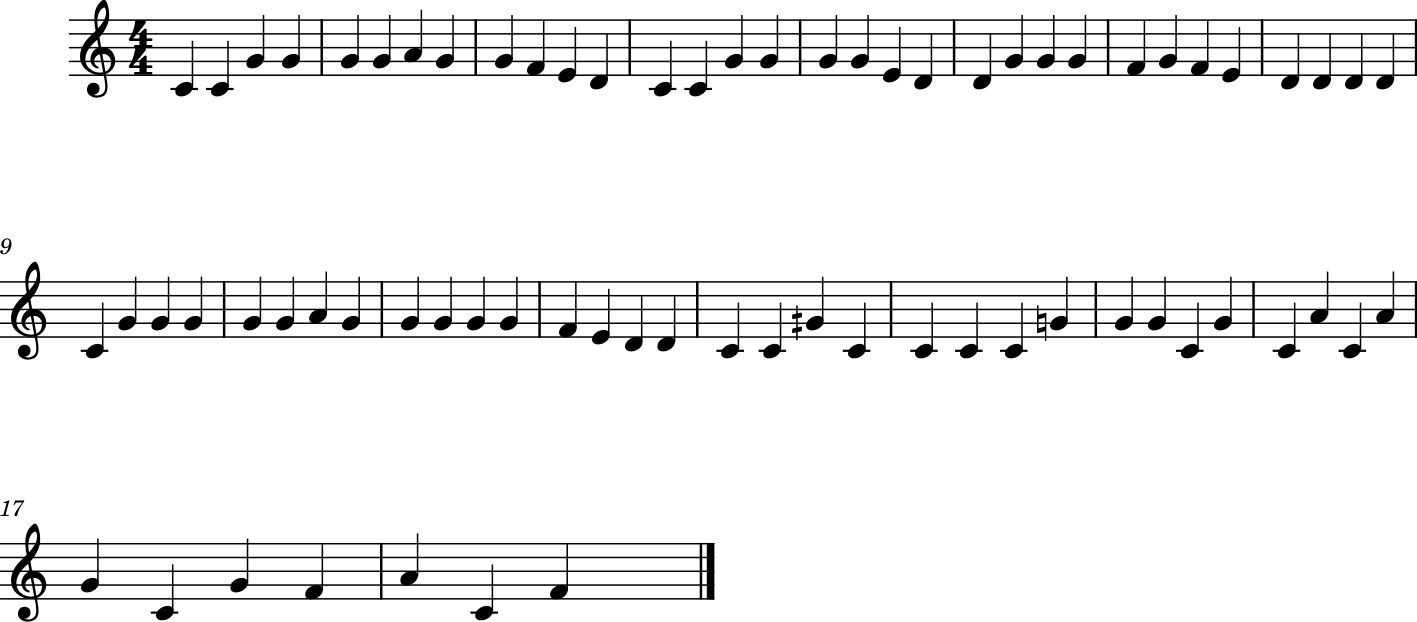

In [127]:
#music, sampling_rate = pureTone(261.63)
music, sampling_rate = userinput()
spec, freq, time = getspec(music, sampling_rate)

maxamps = np.log(np.max(spec,axis=0))
maxfreqs = np.argmax(spec, axis=0)
maxfreqs = freq[maxfreqs]
#print(maxfreqs)
thresh = find_min_amp(maxamps,0.1)
comps = maxamps>thresh
zeroedfreqs = np.trim_zeros(comps*maxfreqs)

timefreq = [(i,[j]) for i,j in enumerate(zeroedfreqs)]
timefreq = dict(timefreq)

sheetMusic(timefreq, num_clusters = 1)